# Classification of handprinted characters

    The purpose of this page is to solve a classification task using Python. The chosen database to be classified is the NIST database, which contains handprinted sample forms of 3600 writers, 810.000 character images isolated from their forms and ground truth classifications for those images.
    
    In order to decrease the time and memory comsumption of this example, the database was restricted to only 100 images per class. NIST database contained 64 different classes of characters.
    
    In this page two different classifiers were trained. One with custom made features and one with features already implemented in other libraries.  

# Workspace setup and database loading

In [1]:
import sys
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
from sarpy.datasets import load_nist
from scipy import ndimage
from skimage.feature import shape_index
from skimage.measure import label
from skimage.measure import regionprops
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import itertools 

dataset = load_nist()

# Classifier training 1

    This demo was trained with features implemented by the group 1 of the Shape Analysis course of IME-USP.

## Feature Extraction

In [2]:
def features(bitmap):
    f = []
    
    label_img = label(bitmap)
    props = regionprops(label_img)
    f.append(props[0].area)
#     f.append(props[0].bbox_area)
    f.append(props[0].convex_area)
    f.append(props[0].eccentricity)
    f.append(props[0].equivalent_diameter)
    f.append(props[0].euler_number)
    f.append(props[0].extent)
    f.append(props[0].filled_area)
    f.append(props[0].minor_axis_length)
    f.append(props[0].major_axis_length)
    f.append(props[0].orientation)
    f.append(props[0].perimeter)
    f.append(props[0].solidity)
    
    moments = np.ravel(props[0].moments_central)
    f.extend(moments)
    inertia = np.ravel(props[0].inertia_tensor)
    f.extend(inertia)
    centroid_raw, centroid_col = props[0].centroid
    f.append(centroid_raw)
    f.append(centroid_col)

    return f

def feature_extraction(data):
    X = data['bitmaps']
    Y = data['targets']

    M = []
    for i in range(len(X)):
        feat = features(X[i].data)
        feat.append(Y[i])
        M.append(feat)
    M = np.asarray(M)   
    return M

mindata = {'bitmaps':dataset['bitmaps'][:],'targets':dataset['targets'][:]}
featured = feature_extraction(mindata)
datasets = [featured]


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Classification algorithm and Results

In [4]:
def fun_classification(data,names,classifiers,arraykfolds,plotCM=False,iterFeatures=False):
    
    data = data[0]
    print(data.shape)
    
        
    for kfolds in arraykfolds:
        print("-----------------")
        print("      DATASET    ")

        # Load X : features and y : labels
        X = data[:,0:data.shape[1]-1]
        y = data[:,data.shape[1]-1]

        # PCA
        pca = PCA()    
        pca.fit(X)
        X = pca.transform(X)
    
        # Standardize features
        X = StandardScaler().fit_transform(X)
        
        print("samples        : ",X.shape[0]) # number of samples
        print("total features : ",X.shape[1]) # number of features
        arrayNumFeatures = []
        if iterFeatures == True:
            arrayNumFeatures = [10,20,X.shape[1]]
        else:
            arrayNumFeatures = [X.shape[1]]
        
        # Initial Plot parameters  
        plt.figure(figsize=(8,8))
        
        # iterate over classifiers names and configurations
        print("\n>> Classifiers")
        print("cross validation, kfolds = ",kfolds,"\n")
        
        for name, clf in zip(names, classifiers):
            print("+",name)
            #plot x and y
            x_graph = [0]
            y_graph =[[0,0]]
        
            # increase number of features at each iteration for comparations
            for j in arrayNumFeatures:  
            
                #Feature Selection KBest            
                ttx = SelectKBest(f_classif,k=j).fit_transform(X,y) 
            
                #Cross validation 5-folds  (5 classifications) SCORES
                scores = cross_val_score(clf, ttx, y, cv=kfolds)
                
                if(plotCM): # plot confusion Matrix
                    #Cross validation 5-folds  (5 classifications) PREDICT -> for matrix confusion 
                    y_pred = cross_val_predict(clf,ttx,y, cv=kfolds)            
                    cnf_matrix = confusion_matrix(y,y_pred);
                    np.set_printoptions(precision=1)
                    # Plot normalized confusion matrix                
                    plt.figure(figsize=(18,18))
                    print(cnf_matrix.shape)
                    strtitle='Confusion matrix - classi:'+str(name)+' - kfolds:'+str(kfolds)+' - #features:'+str(j);
                    plot_confusion_matrix(cnf_matrix,classes=dataset['names'],normalize=True,title=strtitle)
                    plt.savefig(strtitle+'.png',pad_inches=1,bbox_inches='tight', dpi=300)
                    plt.show()
            
                #add results to plot
                x_graph = np.append(x_graph,j)
                y_graph = np.concatenate((y_graph,[[np.mean(scores),np.std(scores)]]),axis=0)
             
            plt.plot(x_graph,y_graph[:,0],label=name)
            
        plt.legend()
        strtitle='Prediction - kfolds:'+str(kfolds)        
        plt.title(strtitle)
        
        plt.xlabel('# of features')
        plt.ylabel('predictions accuracy (%)')
        plt.savefig(strtitle+'.png',pad_inches=1,bbox_inches='tight', dpi=300)
        plt.show()
    

# PCA

    

Principal Component Analysis (PCA) is a statistical technique that uses orthogonal transformations in order to convert possible correlated variables into linearly uncorrelated variables. This transformation is used to increase the variance between variables, so the difference between each pattern can be emphasized.

The intuition behind PCA technique is that, given an amount of feature vectors, the PCA algorithm will transform the dataset to change the basis of the observed variables, so the first feature in the new dataset will have the greatest variance among all features, the second feature will have the second greatest variance, and so forth.

PCA algorithm can be summarized in the following steps:
* Gather the feature vectors of the experiment in the matrix X
* Calculate C, the covariance matrix of X
* Compute the eigenvalues of C and the orthogonal set of eigenvectors
* Build the matrix E, where the columns are the eigenvectors, sorted by the eigenvalues
* The new dataset will be computed as X' = (X - Xm) * E, where Xm is the mean feature vector 

The dimensionality of the resulting feature vector can be reduced by using only the first n features of the X' matrix.

In our example, the PCA is used in the extracted feature vectors to increase the variance among the features. The first method used is 'pca.fit(X)', which fits the model in the dataset X, while the pca.transform(X) applies the dimensionality reduction to the dataset, returning the transformed data.

(6200, 35)
-----------------
      DATASET    
samples        :  6200
total features :  34

>> Classifiers
cross validation, kfolds =  10 

+ Linear SVM
(62, 62)
Normalized confusion matrix


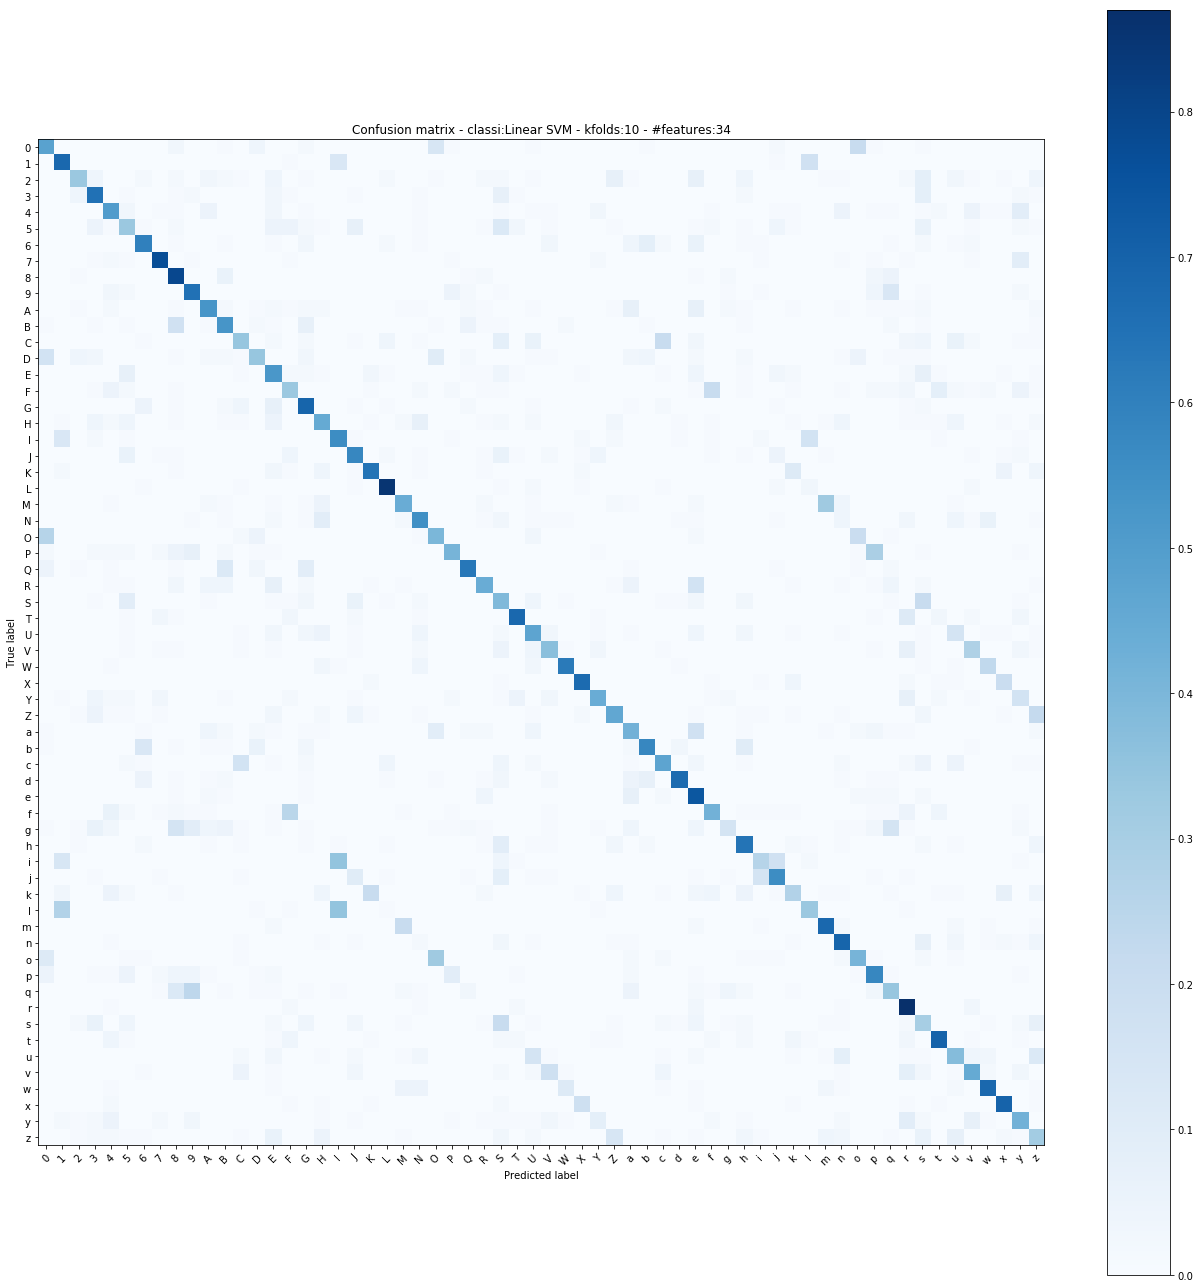

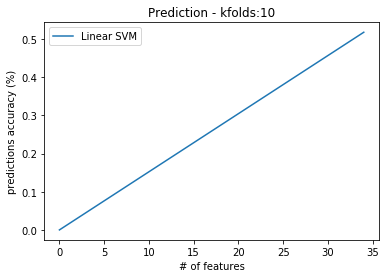

In [5]:
#names = ["Nearest Neighbors", "Linear SVM"]
#classifiers = [ KNeighborsClassifier(3), SVC(kernel="linear", C=0.025)]
#fun_classification(datasets,names,classifiers,[5,10,15],plotCM=False,iterFeatures=True)    

names = ["Linear SVM"]
classifiers = [SVC(kernel="linear", C=0.025)]
fun_classification(datasets,names,classifiers,arraykfolds=[10],plotCM=True,iterFeatures=False)  